In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [30]:
!unzip '/content/Insurance Premium Prediction.zip'

Archive:  /content/Insurance Premium Prediction.zip
  inflating: Insurance Premium Prediction.csv  


In [20]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [21]:
!pip install lightgbm

In [22]:
from pyspark.mllib.stat import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.functions import to_date,col, year, month, dayofmonth, dayofweek, date_format,when,monotonically_increasing_id,sin, cos, lit, floor
from math import pi
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer
from pyspark.sql.types import DoubleType, IntegerType
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_log_error,mean_squared_error, mean_absolute_error, r2_score

import optuna
import lightgbm as lgb

import torch
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [31]:
df=pd.read_csv("/content/Insurance Premium Prediction.csv")

In [32]:
df.shape

(1200000, 21)

In [34]:
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [36]:
df.describe().round(2)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.00,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000.00
mean,599999.50,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,1102.54
std,346410.31,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,865.00
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00
25%,299999.75,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,514.00
50%,599999.50,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00
75%,899999.25,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,1509.00
max,1199999.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00


In [9]:
# Define the target column
target_column = 'Premium Amount'

# Select categorical and numerical columns (initial)
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Premium Amount

Categorical Columns: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical Columns: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Year', 'Day', 'Month', 'Week', 'Premium Amount']


In [37]:
# Define the target column
target_column = 'Premium Amount'

# Select categorical and numerical columns (initial)
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Premium Amount

Categorical Columns: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical Columns: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']


In [10]:
df.describe().round(2)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Year,Day,Month,Week,Premium Amount
count,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00
mean,150234.74,41.14,32414.57,2.01,25.55,1.00,9.57,593.16,5.02,2021.62,15.71,6.49,26.48,1102.54
std,86996.41,13.43,31615.53,1.35,11.82,0.82,5.78,141.10,2.59,1.48,8.81,3.43,14.99,865.00
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,2019.00,1.00,1.00,1.00,20.00
25%,74999.75,30.00,8646.00,1.00,16.55,0.00,5.00,484.00,3.00,2020.00,8.00,4.00,14.00,514.00
50%,149999.50,41.00,23918.00,2.00,24.57,1.00,10.00,595.00,5.00,2022.00,16.00,6.00,26.00,872.00
75%,224999.25,53.00,43936.00,3.00,33.77,1.00,15.00,706.00,7.00,2023.00,23.00,9.00,39.00,1509.00
max,307303.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,2024.00,31.00,12.00,53.00,4999.00


In [38]:
for column in categorical_columns:
    num_unique = df[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Gender' has 2 unique categories.
'Marital Status' has 3 unique categories.
'Education Level' has 4 unique categories.
'Occupation' has 3 unique categories.
'Location' has 3 unique categories.
'Policy Type' has 3 unique categories.
'Policy Start Date' has 167381 unique categories.
'Customer Feedback' has 3 unique categories.
'Smoking Status' has 2 unique categories.
'Exercise Frequency' has 4 unique categories.
'Property Type' has 3 unique categories.


In [39]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df[column].value_counts().head(10)}")


Top value counts in 'Gender':
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Top value counts in 'Marital Status':
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Top value counts in 'Education Level':
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Top value counts in 'Occupation':
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Top value counts in 'Location':
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Top value counts in 'Policy Type':
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Top value counts in 'Policy Start Date':
Policy Start Date
2020-02-08 15:21:39.134960    142
2023-08-13 15:21:39.155231    137
2022-02-02 15:21:39.134960    137
2022-08-30 15:21:3

In [40]:
print("The mean of columns:")
print(df[numerical_columns].mean())

print("\nThe std dev of columns:")
print(df[numerical_columns].std())

print("\nThe skewness of columns:")
print(df[numerical_columns].skew())

The mean of columns:
id                      599999.500000
Age                         41.145563
Annual Income            32745.217777
Number of Dependents         2.009934
Health Score                25.613908
Previous Claims              1.002689
Vehicle Age                  9.569889
Credit Score               592.924350
Insurance Duration           5.018219
Premium Amount            1102.544822
dtype: float64

The std dev of columns:
id                      346410.305852
Age                         13.539950
Annual Income            32179.506124
Number of Dependents         1.417338
Health Score                12.203462
Previous Claims              0.982840
Vehicle Age                  5.776189
Credit Score               149.981945
Insurance Duration           2.594331
Premium Amount             864.998859
dtype: float64

The skewness of columns:
id                      3.836279e-16
Age                    -1.253192e-02
Annual Income           1.470357e+00
Number of Dependents   -1.3

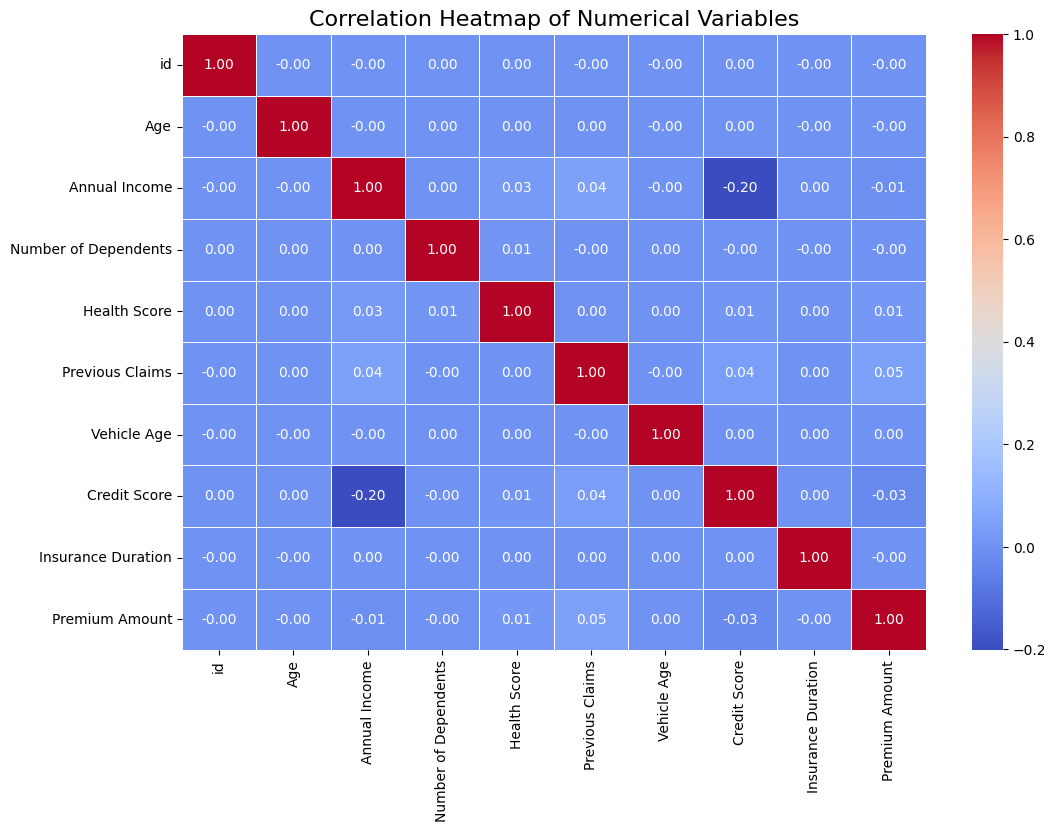

In [41]:
# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

In [42]:
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7

    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

# Apply the date function to both datasets
train_df = date(df)

In [43]:
# Split train data into features and target
X = train_df.drop(columns=[target_column, 'id', 'Group', 'Year', 'Month', 'Day', 'Week'])
y = train_df[target_column]

In [53]:
# Define the target column
target_column = 'Premium Amount'

# Select categorical and numerical columns (initial)
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

In [54]:
# Preprocessing pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())                       # Scale numerical features
])

# Preprocessing pipeline for categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # Encode categorical features
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_columns),
        ('cat', cat_pipeline, categorical_columns)
    ]
)

# Preprocess train and test data
X_processed = preprocessor.fit_transform(X)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [56]:
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 200, 512),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 16),  # -1 means no limit
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0),
        "seed" : 42

    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)

    # Compute RMSLE using sklearn's root_mean_squared_log_error
    rmsle = root_mean_squared_log_error(y_val, np.maximum(y_val_pred, 0))
    return rmsle

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

[I 2025-02-04 09:53:16,570] A new study created in memory with name: no-name-822cde06-9295-4970-925e-4f422bd32580
<ipython-input-56-59944fd96c73>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
<ipython-input-56-59944fd96c73>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
<ipython-input-56-59944fd96c73>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("baggin

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 66
[LightGBM] [Info] Start training from score 1102.505529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-02-04 09:53:57,355] Trial 0 finished with value: 1.1344767002609264 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 477, 'learning_rate': 0.05252134674337178, 'feature_fraction': 0.873123056455452, 'bagging_fraction': 0.6402369103113789, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'max_depth': 10, 'lambda_l1': 3.69451605682974, 'lambda_l2': 0.09948173213828994}. Best is trial 0 with value: 1.1344767002609264.


In [57]:
# Initialize or update the best_params dictionary
best_params = {'boosting_type': 'gbdt', 'num_leaves': 477, 'learning_rate': 0.05252134674337178, 'feature_fraction': 0.873123056455452, 'bagging_fraction': 0.6402369103113789, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'max_depth': 10, 'lambda_l1': 3.69451605682974, 'lambda_l2': 0.09948173213828994,'seed':42}

In [58]:
final_model = lgb.train(
    best_params,
    lgb.Dataset(X_processed, label=y),
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.037670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 66
[LightGBM] [Info] Start training from score 1102.544822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 


Performance Metrics:
------------------------------
RMSLE: 1.1256
RMSE: 825.5033
MAE: 622.8993
R²: 0.0892
MAPE: 297.28%


<ipython-input-59-38e01767c05f>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")


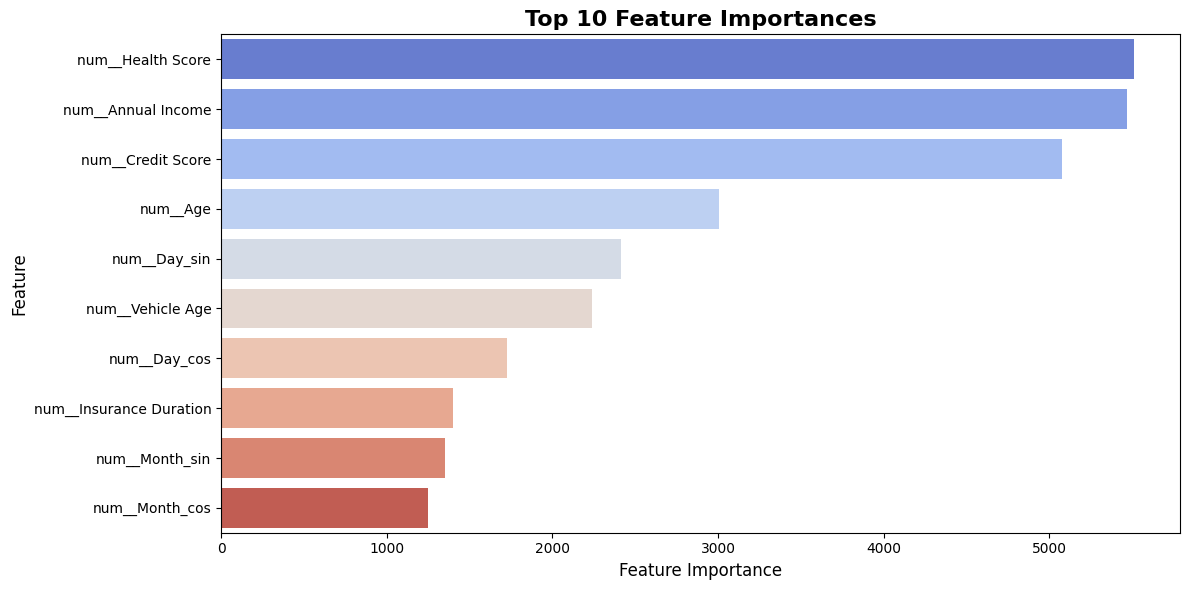

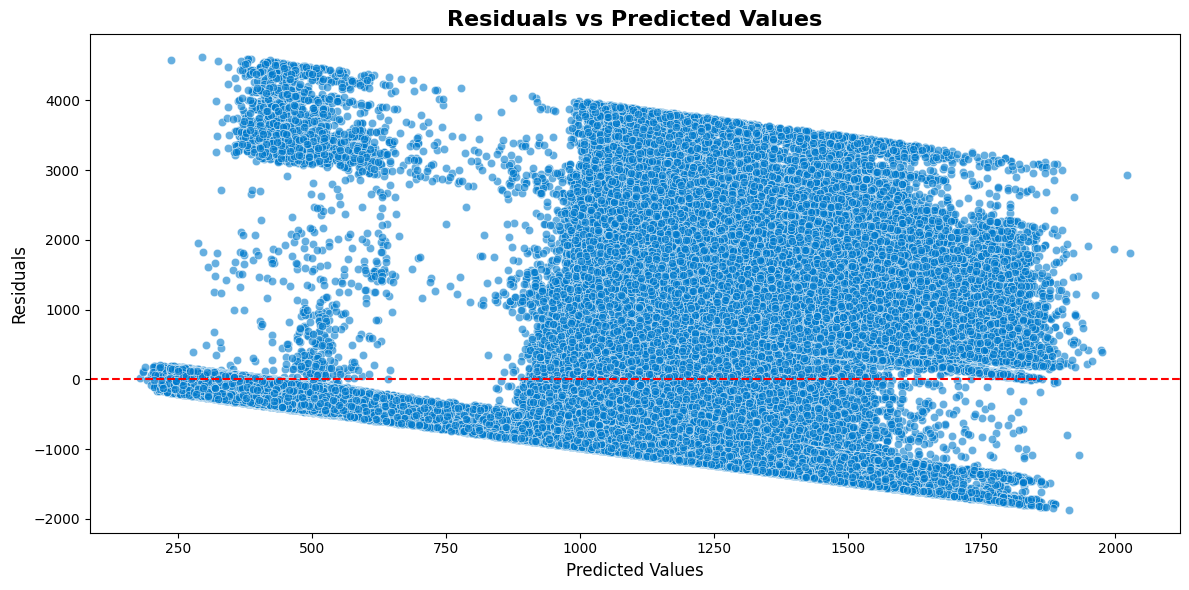

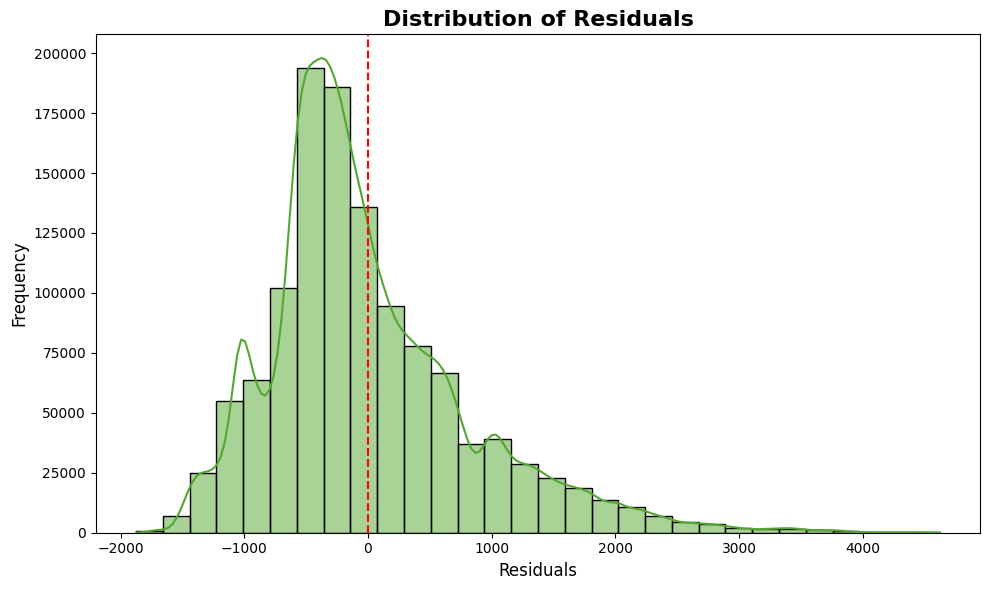

In [59]:
# 1. Performance Metrics
y_pred = final_model.predict(X_processed)

# Calcul des métriques
rmsle = root_mean_squared_log_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

# Display performance metrics
print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# 2. Feature Importance
importances = final_model.feature_importance(importance_type='split')  # or 'gain'
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Residual Analysis
residuals = y - y_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [60]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)